In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
from xopt import Xopt
import yaml

# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")

YAML = """
xopt:
    dump_file: dump.yaml
generator:
    name: bayesian_exploration

evaluator:
    function: xopt.resources.test_functions.tnk.evaluate_TNK

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    constants: {a: dummy_constant}

"""
yaml_output = yaml.safe_load(YAML)

In [2]:
X = Xopt(config=yaml_output)

# for testing purposes only
if SMOKE_TEST:
    X.generator.numerical_optimizer.n_restarts = 1
    X.generator.n_monte_carlo_samples = 1

X


            Xopt
________________________________
Version: 0+untagged.1.g9067c79
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: true, dump_file: dump.yaml, max_evaluations: null}
generator:
  name: bayesian_exploration
  model: null
  turbo_controller: null
  use_cuda: false
  model_constructor:
    name: standard
    use_low_noise_prior: true
    covar_modules: {}
    mean_modules: {}
    trainable_mean_keys: []
  numerical_optimizer: {name: LBFGS, n_raw_samples: 20, n_restarts: 20, max_iter: 2000}
  max_travel_distances: null
  fixed_features: null
  computation_time: {}
  n_candidates: 1
  n_monte_carlo_samples: 128
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0, raise_probability: 0}
  vectorized: false
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZE}
  constants: {a: dummy

In [3]:
X.random_evaluate(5)

for i in range(5):
    print(f"step {i}")
    X.step()

step 0
step 1
step 2
step 3
step 4


In [4]:
print(X.data)

          x1        x2               a        y1        y2        c1  \
1   1.350729  1.894116  dummy_constant  1.350729  1.894116  4.500528   
2   0.005495  2.439266  dummy_constant  0.005495  2.439266  4.850114   
3   0.377912  2.219192  dummy_constant  0.377912  2.219192  4.157985   
4   0.641501  1.017567  dummy_constant  0.641501  1.017567  0.538073   
5   1.922954  1.355897  dummy_constant  1.922954  1.355897  4.628254   
6   0.000000  0.000000  dummy_constant  0.000000  0.000000 -1.100000   
7   1.280974  0.000000  dummy_constant  1.280974  0.000000  0.540893   
8   0.756260  0.882746  dummy_constant  0.756260  0.882746  0.317964   
9   0.928198  0.719719  dummy_constant  0.928198  0.719719  0.422383   
10  0.492339  1.011967  dummy_constant  0.492339  1.011967  0.209261   

          c2  xopt_runtime  xopt_error  
1   2.667300      0.000067       False  
2   4.005288      0.000010       False  
3   2.970526      0.000008       False  
4   0.287898      0.000007       False  
5 

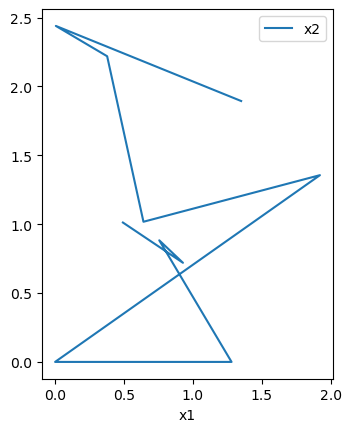

In [5]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

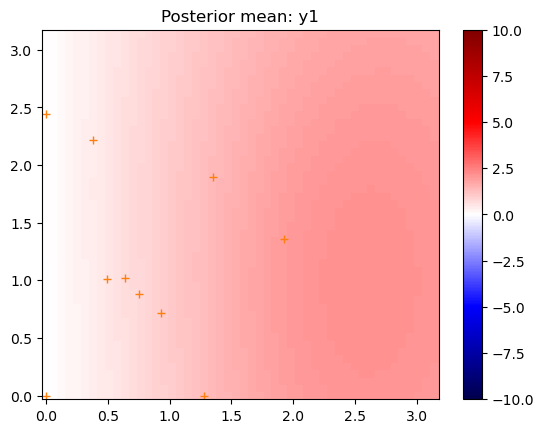

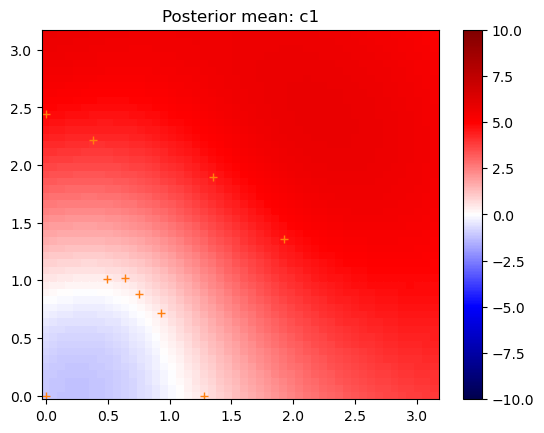

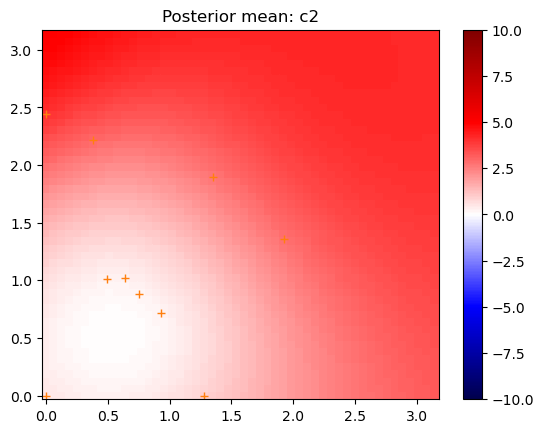

In [6]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh
n = 50
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = X.generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    for i in range(len(X.vocs.output_names)):
        mean = post.mean[...,i]
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax.pcolor(
            xx, yy, mean.squeeze().reshape(n, n),
            cmap="seismic",
            vmin=-10.0,
            vmax=10.0)
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

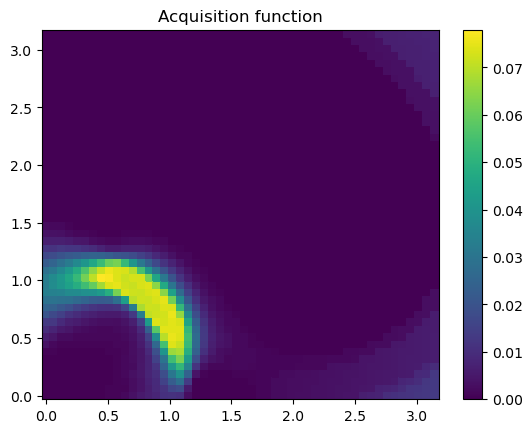

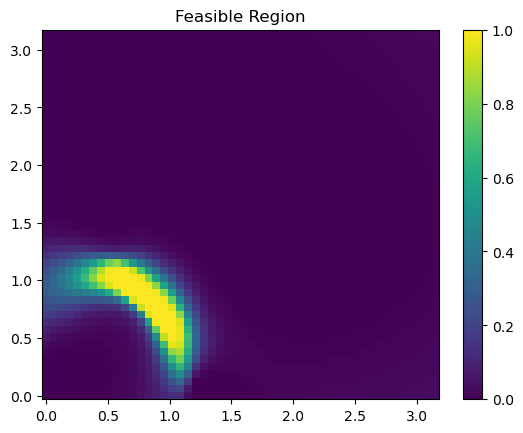

In [7]:
from xopt.generators.bayesian.objectives import feasibility

acq_func = X.generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n))
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    feas = feasibility(pts.unsqueeze(1), model, X.vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")